Calculator of the infection probability for the PCR test of COVID-19:

$$
p(\text{infected}|\text{positive})=\frac{p(\text{positive}|\text{infected})p(\text{infected})}{p(\text{positive}|\text{infected})p(\text{infected})+p(\text{positive}|\text{uninfected})p(\text{uninfected})}\\
p(\text{positive}|\text{infected})=\text{sensitivity}\\
p(\text{positive}|\text{uninfected})=1-\text{specificity}
$$

In [1]:
def infection_probability(prior_infected, sensitivity=0.7, specificity=0.99):
  p = sensitivity * prior_infected / (sensitivity * prior_infected + (1-specificity)*(1-prior_infected))
  return p

infection_probability(0.001)

0.06548175865294663

In [2]:
infection_probability(0.001, sensitivity=0.7, specificity=0.9999)

0.8751093886735962

Exercise
1. Change prior_infected, sensitivity, and specificity, and consider how we can perform a meaningful test.

Local trend model (smooth curve model) with PyMC

$$
p(\mu_i)=\frac{1}{\sqrt{2\pi\lambda^2}}
\exp\left\{ -
  \frac{((\mu_i-\mu_{i-1})-(\mu_{i-1}-\mu_{i-2}))^2}
  {2\lambda^2} \right\}\\
  =\frac{1}{\sqrt{2\pi\lambda^2}}
\exp\left\{ -
  \frac{(\mu_i-2\mu_{i-1}+\mu_{i-2})^2}
  {2\lambda^2} \right\}
$$

In [3]:
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt

import jax
from jax import random
import jax.numpy as jnp

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [4]:
print(jax.devices())

[CpuDevice(id=0)]


In [5]:
device = jax.default_device()
print(f"Using device: {device}")

Using device: <contextlib._GeneratorContextManager object at 0x000001C87810B4D0>


<ErrorbarContainer object of 3 artists>

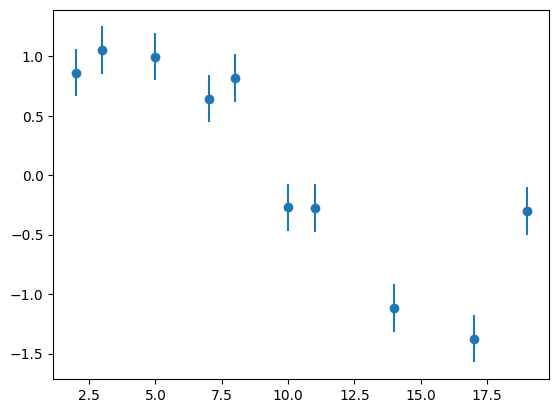

In [6]:
# Generate data
# N : the number of data
# M : the number of complete data
# sigma : the standard deviation of Gaussian noise
def generate_synthetic_data(N, M=20, sigma=0.2):
  t = np.random.choice(np.arange(1,M), N, replace=False)
  y = np.sin(2*np.pi*t/M) + np.random.normal(0,sigma,N)
  ye = np.repeat(sigma,N)
  return t, y, ye

N = 10
M = 20
sigma = 0.2
t, y, ye = generate_synthetic_data(N, M, sigma)
plt.errorbar(t,y,ye,fmt='o')

In [14]:
# PyMC model
# The lambda value (lmd) is set manually.
lmd = 0.2
with pm.Model() as model:
    # Prior for mu
    mu = pm.Normal('mu', mu=0, sigma=10, shape=M)
    # Local trend model (auto-regresive structure of mu)
    for i in range(2, M):
        pm.Potential(f'mu_potential_{i}', pm.logp(pm.Normal.dist(mu=2*mu[i - 1]-mu[i - 2], sigma=lmd), mu[i]))
    # Data model
    y_obs = pm.Normal('y_obs', mu=mu[t-1], sigma=ye, observed=y)

In [15]:
# MCMC sampling
with model:
    samples = pm.sample(1000, tune=1000, chains=1, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu]


Output()

Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 3 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [16]:
pm.summary(samples)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu[0],0.827,0.379,0.093,1.488,0.011,0.008,1175.0,758.0,NaN
mu[1],0.910,0.180,0.578,1.232,0.006,0.004,1009.0,657.0,NaN
mu[2],0.997,0.141,0.739,1.253,0.005,0.003,877.0,867.0,NaN
mu[3],1.025,0.170,0.741,1.366,0.006,0.004,923.0,704.0,NaN
mu[4],0.993,0.162,0.722,1.305,0.005,0.004,894.0,840.0,NaN
mu[5],0.901,0.162,0.599,1.200,0.005,0.004,904.0,937.0,NaN
mu[6],0.765,0.137,0.518,1.016,0.004,0.003,981.0,700.0,NaN
mu[7],0.593,0.138,0.354,0.848,0.004,0.003,1064.0,868.0,NaN
mu[8],0.267,0.152,-0.013,0.553,0.005,0.004,926.0,715.0,NaN
mu[9],-0.092,0.137,-0.345,0.159,0.004,0.003,1037.0,812.0,NaN


array([[<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>]],
      dtype=object)

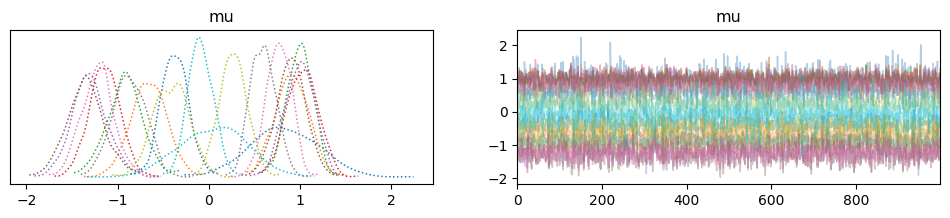

In [17]:
pm.plot_trace(samples, combined=True)

<ErrorbarContainer object of 3 artists>

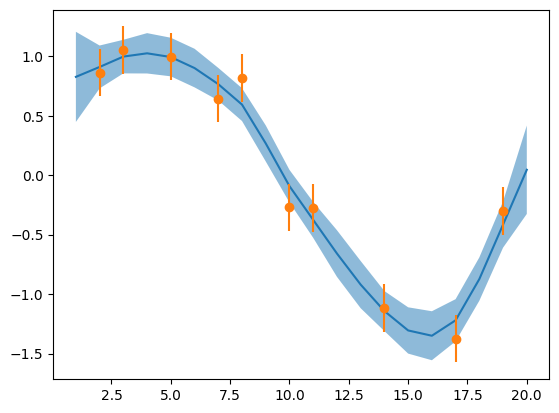

In [18]:
# Calculate mean and standard deviation in one go
y_pred = samples.posterior['mu'].mean(axis=(0, 1))
ye_pred = samples.posterior['mu'].std(axis=(0, 1))
x_pred = np.linspace(1, M, M)
# Plot prediction
plt.plot(x_pred, y_pred)
plt.fill_between(x_pred, y_pred-ye_pred, y_pred+ye_pred, alpha=0.5)
plt.errorbar(t, y, ye, fmt='o')

Exercise
2. Change lambda, and see too smooth model and overfitted model.